In [33]:
# variational autoencoder for lesion segmentation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision.utils import save_image
import os
import nibabel as nib
import cv2
import random
import h5py

In [8]:
data_path = 'IXI-T2'
data_files = [f for f in os.listdir(data_path) if f.endswith('.nii.gz')]
all_data = []

for data_file_id in range(250):
    file_path = os.path.join(data_path, data_files[data_file_id])
    image_nii = nib.load(file_path)
    image_array = image_nii.get_fdata()

    for i in range(image_array.shape[2]):
        slice_image = image_array[:, :, i]
        slice_image = (slice_image - np.min(slice_image)) / (np.max(slice_image) - np.min(slice_image))
        slice_image = cv2.resize(slice_image, (256, 256))
        all_data.append(slice_image)

In [12]:
# form train dataset from all_data
train_dataset = np.array(all_data)
train_dataset = train_dataset[:, np.newaxis, :, :]
train_dataset = torch.from_numpy(train_dataset).float()

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [15]:
# hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 10

# encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(256*256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
       
    def forward(self, x):
        x = x.view(-1, 256*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return x

# decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 256*256)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = x.view(-1, 1, 256, 256)
        return x

# VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# model, loss function and optimizer
model = VAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train
for epoch in range(num_epochs):
    for i in range(0, len(train_dataset), batch_size):
        input_data = train_dataset[i:i+batch_size]
        output_data = model(input_data)
        loss = criterion(output_data, input_data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/10], loss:0.0311
epoch [1/10], loss:0.0309
epoch [1/10], loss:0.0278
epoch [1/10], loss:0.0257
epoch [1/10], loss:0.0222
epoch [1/10], loss:0.0291
epoch [1/10], loss:0.0207
epoch [1/10], loss:0.0202
epoch [1/10], loss:0.0213
epoch [1/10], loss:0.0219
epoch [1/10], loss:0.0202
epoch [1/10], loss:0.0201
epoch [1/10], loss:0.0198
epoch [1/10], loss:0.0199
epoch [1/10], loss:0.0202
epoch [1/10], loss:0.0203
epoch [1/10], loss:0.0206
epoch [1/10], loss:0.0201
epoch [1/10], loss:0.0191
epoch [1/10], loss:0.0187
epoch [1/10], loss:0.0190
epoch [1/10], loss:0.0194
epoch [1/10], loss:0.0187
epoch [1/10], loss:0.0195
epoch [1/10], loss:0.0191
epoch [1/10], loss:0.0189
epoch [1/10], loss:0.0180
epoch [1/10], loss:0.0197
epoch [1/10], loss:0.0180
epoch [1/10], loss:0.0183
epoch [1/10], loss:0.0185
epoch [1/10], loss:0.0184
epoch [1/10], loss:0.0195
epoch [1/10], loss:0.0190
epoch [1/10], loss:0.0188
epoch [1/10], loss:0.0194
epoch [1/10], loss:0.0190
epoch [1/10], loss:0.0181
epoch [1/10]

In [27]:
# test
model.eval()
with torch.no_grad():
    for i, x in enumerate(DataLoader(test_dataset[0:5], batch_size=batch_size, shuffle=True)):
        x = x.view(-1, 256*256)
        x = Variable(x)
        x_recon = model(x)

        if i == 0:
            x = x.view(-1, 1, 256, 256)
            x_recon = x_recon.view(-1, 1, 256, 256)
            x_diff = torch.abs(x - x_recon)
            x_diff = x_diff.view(-1, 1, 256, 256)
            x_concat = torch.cat([x, x_recon, x_diff], dim=3)
            save_image(x_diff, 'vae_recon.png')
            break

In [28]:
# save model
torch.save(model.state_dict(), 'vae.pth')
# load model
model.load_state_dict(torch.load('vae.pth'))

<All keys matched successfully>

In [34]:
# new line 
directory = 'archive/BraTS2020_training_data/content/data'

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


In [35]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

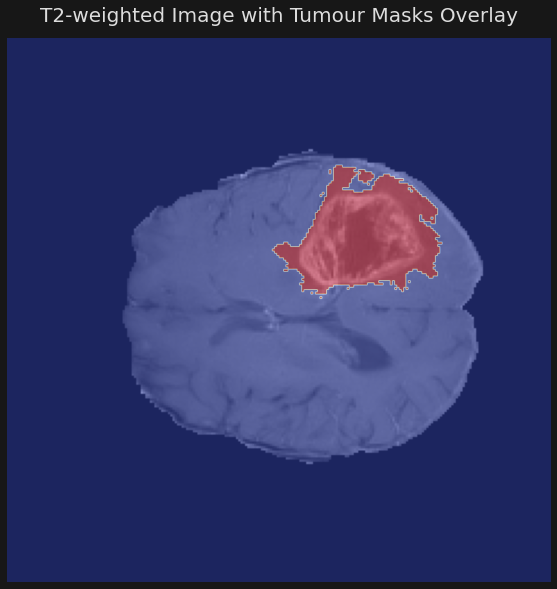

In [49]:
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[11600])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

image_t2 = image[2, :, :]
mask_all = mask[0, :, :] + mask[1, :, :] + mask[2, :, :]

plt.figure(figsize=(10, 10))
plt.imshow(image_t2, cmap='gray')
plt.imshow(mask_all, cmap='coolwarm', alpha=0.5)
plt.axis('off')
plt.title('T2-weighted Image with Tumour Masks Overlay', fontsize=20, y=1.02)
plt.show()

In [50]:
model.eval()
with torch.no_grad():
    #resize 256x256
    x = image_t2
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x = cv2.resize(x, (256, 256))
    x = torch.from_numpy(x).float()
    x = x.view(-1, 256*256)
    x = Variable(x)
    x_recon = model(x)


    x = x.view(-1, 1, 256, 256)
    x_recon = x_recon.view(-1, 1, 256, 256)
    x_diff = torch.abs(x - x_recon)
    x_diff = x_diff.view(-1, 1, 256, 256)
    x_concat = torch.cat([x, x_recon, x_diff], dim=3)
    save_image(x_concat, 'vae_recon.png')